In [1]:
#!/usr/bin/env python
# coding: utf-8
# (c) Charles Le Losq, Clément Ferraina 2023
# see embedded licence file
# iVisc 1.0

#
# Library Loading
#
import pandas as pd # manipulate dataframes
import matplotlib.pyplot as plt # plotting
import numpy as np
np.random.seed = 167 # fix random seed for reproducibility

import time, os

# local imports
import src.utils as utils
import src.ivisc as ivisc

# import sklearn models
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn import linear_model

# import sklearn utils
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.preprocessing import StandardScaler

from tqdm import tqdm

# deep learning libraries
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import torch

# import joblib (save and load models)
import joblib

#
# First we check if CUDA is available
#
device = utils.get_default_device()

2024-01-25 17:24:44.421836: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


CUDA AVAILABLE? 
No, setting device to cpu


In [2]:
# Loading data used to train the models

print("Loading the viscosity datasets...")
ds = ivisc.data_loader(path_viscosity='./data/all_viscosity.hdf5')
ds.print_data()
print("Loaded.")

Loading the viscosity datasets...
################################
#### Dataset specifications ####
################################

Number of unique compositions (viscosity): 2912
Number of unique compositions in training (viscosity): 2258
Dataset separations are 0.78 in train, 0.11 in valid, 0.11 in test

This is for checking the shape consistency of the dataset:

Visco train shape
(11767, 155)
(11767, 1)
(11767, 1)
Loaded.


In [3]:
# Loading previously trained models

#Linear Regression
clf_linreg = joblib.load('./models/clf_linreg.joblib')

# Support Vector Machine regression
clf_svr = joblib.load('./models/clf_svr.joblib')

# Artificial Neural Network
clf_nn = joblib.load('./models/clf_nn.joblib')

# Random Forest Regressor
clf_rf = joblib.load('./models/clf_rf.joblib')

# Greybox Neural Network
model_1 = tf.keras.models.load_model('./models/model1_best.keras', 
                                     custom_objects={'MyegaCalculationLayer_model1': ivisc.MyegaCalculationLayer_model1})
model_2 = tf.keras.models.load_model('./models/model2_best.keras', 
                                     custom_objects={'MyegaCalculationLayer_model2': ivisc.MyegaCalculationLayer_model2})


print('Loaded.')

Loaded.


In [4]:
utils.evaluate_blackbox_model(ds, clf_linreg, "LINEAR REGRESSION")
utils.evaluate_blackbox_model(ds, clf_svr, "SUPPORT VECTOR MACHINE")
utils.evaluate_blackbox_model(ds, clf_rf, "RANDOM FOREST")
utils.evaluate_blackbox_model(ds, clf_nn, "ARTIFICIAL NEURAL NETWORK")

LINEAR REGRESSION
Root Mean Square Errors: 
 Train    1.17 
 Valid    1.21 
 Test     1.24 
Coefficient of Determination: 
 Train    0.94 
 Valid    0.94 
 Test     0.93
SUPPORT VECTOR MACHINE
Root Mean Square Errors: 
 Train    0.40 
 Valid    0.35 
 Test     1.76 
Coefficient of Determination: 
 Train    0.99 
 Valid    0.99 
 Test     0.87
RANDOM FOREST
Root Mean Square Errors: 
 Train    0.13 
 Valid    0.14 
 Test     0.44 
Coefficient of Determination: 
 Train    1.00 
 Valid    1.00 
 Test     0.99
ARTIFICIAL NEURAL NETWORK
Root Mean Square Errors: 
 Train    0.30 
 Valid    0.28 
 Test     0.48 
Coefficient of Determination: 
 Train    1.00 
 Valid    1.00 
 Test     0.99


In [5]:
# Greybox model evaluation
y_train_model = model_1.predict((ds.PX_train_scaled,ds.T_train))
y_valid_model = model_1.predict((ds.PX_valid_scaled,ds.T_valid))
y_test_model = model_1.predict((ds.PX_test_scaled,ds.T_test))

model_mse_train = mean_squared_error(ds.y_train, y_train_model, squared=False)
model_mse_valid = mean_squared_error(ds.y_valid, y_valid_model, squared=False)
model_mse_test = mean_squared_error(ds.y_test, y_test_model, squared=False)

model_r2_train = r2_score(ds.y_train, y_train_model)
model_r2_valid = r2_score(ds.y_valid, y_valid_model)
model_r2_test = r2_score(ds.y_test, y_test_model)

# i-visc model evaluation
y_train_ivisc = model_2.predict((ds.X_train_scaled, ds.T_train, ds.P_train, ))
y_valid_ivisc = model_2.predict((ds.X_valid_scaled, ds.T_valid, ds.P_valid, ))
y_test_ivisc = model_2.predict((ds.X_test_scaled, ds.T_test, ds.P_test, ))

ivisc_mse_train = mean_squared_error(ds.y_train,y_train_ivisc, squared=False)
ivisc_mse_valid = mean_squared_error(ds.y_valid,y_valid_ivisc, squared=False)
ivisc_mse_test = mean_squared_error(ds.y_test,y_test_ivisc, squared=False)

ivisc_r2_train = r2_score(ds.y_train,y_train_ivisc)
ivisc_r2_valid = r2_score(ds.y_valid,y_valid_ivisc)
ivisc_r2_test = r2_score(ds.y_test,y_test_ivisc)

# Greybox model 1
print('Greybox Model','\n',
      'Root Mean Square Errors:','\n',
      ' Train    %.2f' % model_mse_train,'\n',
      ' Valid    %.2f' % model_mse_valid,'\n',
      ' Test     %.2f' % model_mse_test,'\n'
      ' Coefficient of Determination:','\n',
      ' Train    %.2f' % model_r2_train,'\n',
      ' Valid    %.2f' % model_r2_valid,'\n',
      ' Test     %.2f' % model_r2_test,'\n'
     )
# i-visc model 2
print('i-visc Greybox Model','\n',
      'Root Mean Square Errors:','\n',
      ' Train    %.2f' % ivisc_mse_train,'\n',
      ' Valid    %.2f' % ivisc_mse_valid,'\n',
      ' Test     %.2f' % ivisc_mse_test,'\n'
      ' Coefficient of Determination:','\n',
      ' Train    %.2f' % ivisc_r2_train,'\n',
      ' Valid    %.2f' % ivisc_r2_valid,'\n',
      ' Test     %.2f' % ivisc_r2_test,'\n'
     )

53/53 [==============================] - 0s 2ms/step
Greybox Model 
 Root Mean Square Errors: 
  Train    0.43 
  Valid    0.51 
  Test     0.55 
 Coefficient of Determination: 
  Train    0.99 
  Valid    0.99 
  Test     0.99 

i-visc Greybox Model 
 Root Mean Square Errors: 
  Train    0.46 
  Valid    0.54 
  Test     0.55 
 Coefficient of Determination: 
  Train    0.99 
  Valid    0.99 
  Test     0.99 



In [27]:
def models_predict(ds, model, selected="blackbox"):
    if selected == "blackbox":
        return (model.predict(ds.TPX_train_scaled), 
                model.predict(ds.TPX_valid_scaled), 
                model.predict(ds.TPX_test_scaled))
    elif selected == "greybox1":
        return (model.predict((ds.PX_train_scaled, ds.T_train)), 
                model.predict((ds.PX_valid_scaled, ds.T_valid)), 
                model.predict((ds.PX_test_scaled, ds.T_test)))
    elif selected == "greybox2":
        return (model.predict((ds.X_train_scaled, ds.T_train, ds.P_train)), 
                model.predict((ds.X_valid_scaled, ds.T_valid, ds.P_valid)), 
                model.predict((ds.X_test_scaled, ds.T_test, ds.P_test)))

In [12]:
predictions_linear = models_predict(ds, clf_linreg, "blackbox")
predictions_svr = models_predict(ds, clf_svr, "blackbox")
predictions_rf = models_predict(ds, clf_rf, "blackbox")
predictions_nn = models_predict(ds, clf_nn, "blackbox")

In [28]:
predictions_gm1 = models_predict(ds, model_1, "greybox1")

53/53 [==============================] - 0s 2ms/step


In [29]:
predictions_gm2 = models_predict(ds, model_2, "greybox2")

53/53 [==============================] - 0s 2ms/step


Text(0.5, 25.722222222222214, 'Measured Viscosity, log$_{10}$ Pa$\\cdot$s')

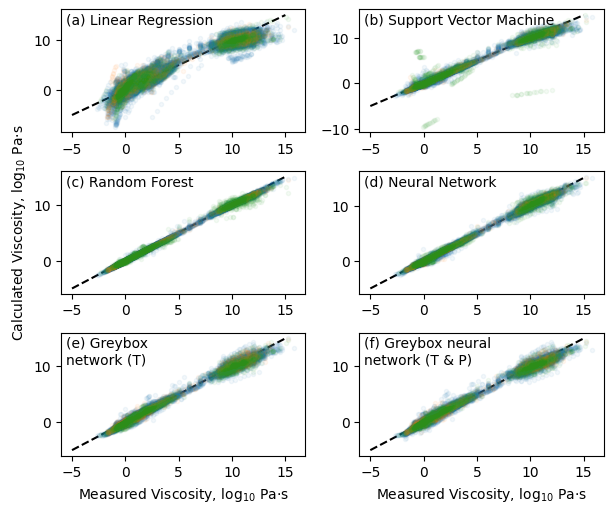

In [55]:
def make_subplot(ax, ds, prediction, title="something"):
    ax.plot([-5,15],[-5,15],'k--')
    ax.plot(ds.y_train,prediction[0],'.', color= "C0", alpha=0.05)
    ax.plot(ds.y_valid,prediction[1],'.', color= "C1", alpha=0.05)
    ax.plot(ds.y_test,prediction[2],'.', color= "C2", alpha=0.05)
    ax.annotate(title, xy=(0.02,0.97), xycoords="axes fraction", va="top")

# All graphs together for better comparaison
fig = plt.figure(figsize=(6,5))

ax_lin = plt.subplot(3,2,1)
ax_svr = plt.subplot(3,2,2)
ax_rf = plt.subplot(3,2,3)
ax_nn = plt.subplot(3,2,4)
ax_grey = plt.subplot(3,2,5)
ax_ivisc = plt.subplot(3,2,6)

make_subplot(ax_lin, ds, predictions_linear, title="(a) Linear Regression")
make_subplot(ax_svr, ds, predictions_svr, title="(b) Support Vector Machine")
make_subplot(ax_rf, ds, predictions_rf, title="(c) Random Forest")
make_subplot(ax_nn, ds, predictions_nn, title="(d) Neural Network")
make_subplot(ax_grey, ds, predictions_gm1, title="(e) Greybox \nnetwork (T)")
make_subplot(ax_ivisc, ds, predictions_gm2, title="(f) Greybox neural \nnetwork (T & P)")
plt.tight_layout()

ax_rf.set_ylabel("Calculated Viscosity, log$_{10}$ Pa$\cdot$s")
ax_grey.set_xlabel("Measured Viscosity, log$_{10}$ Pa$\cdot$s")
ax_ivisc.set_xlabel("Measured Viscosity, log$_{10}$ Pa$\cdot$s")

# Prediction for one composition

We compare the blackbox models for the prediction of the viscosity of a given composition

7/7 [==============================] - 0s 2ms/step
Number of data = 52


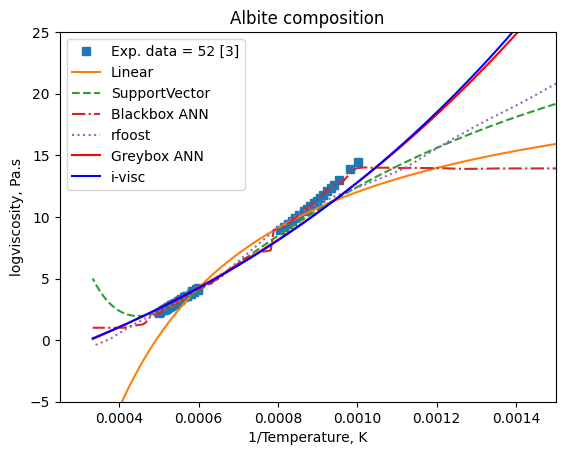

In [76]:
def predict_one_compo(di_, # subset
                      ds, # data object
                      models, # list of the models
                      T_interest,
                      P_interest):

    # add descriptors
    xi_ = utils.descriptors(di_.loc[:, utils.list_oxides()]/100).values

    # same composition so we get first line, then create an array with interesting temps
    xi = np.ones((len(T_interest),xi_.shape[1]))*xi_[0,:]

    # transformation
    ptxi_scaled = ds.scale_for_bbm(xi, 
                                   T_interest.reshape(-1,1), 
                                   P_interest.reshape(-1,1))

    pxi_scaled = ds.scale_for_gb1(xi, 
                                  P_interest.reshape(-1,1))
    
    xi_scaled = ds.scaler_X.transform(xi)

    # predictions 
    oneC_lin = models[0].predict(ptxi_scaled)
    oneC_svr = models[1].predict(ptxi_scaled)
    oneC_nn = models[2].predict(ptxi_scaled)
    oneC_rf = models[3].predict(ptxi_scaled)
    oneC_grey = models[4].predict((pxi_scaled, T_interest.reshape(-1,1)))
    oneC_ivisc = models[5].predict((xi_scaled,
                                     T_interest.reshape(-1,1), 
                                     P_interest.reshape(-1,1)))
    predictions = (oneC_lin,oneC_svr,oneC_nn,oneC_rf,oneC_grey,oneC_ivisc)
    return predictions
    
models_list = [clf_linreg, clf_svr, clf_rf, clf_nn, model_1, model_2]
# Composition Albite NAK75_12_0 LL2013

# loading data of interest
di_ = ds.dataset_lp.loc[(ds.dataset_lp.Name_publi=="NAK75_12_0")|
                     (ds.dataset_lp.Name_publi=="Ab"),:].reset_index()

T_interest = np.linspace(500, 3000.0, 200)
P_interest = np.zeros(len(T_interest))
predictions_albite = predict_one_compo(di_, ds, models_list, T_interest, P_interest)

# figure
plt.figure()
plt.plot(1/di_.loc[:,"T"], di_.viscosity,"s",label="Exp. data = 52 [3]")
plt.plot(1/T_interest, predictions_albite[0],"-",label="Linear")
plt.plot(1/T_interest, predictions_albite[1],"--",label="SupportVector")
plt.plot(1/T_interest, predictions_albite[2],"-.",label="Blackbox ANN")
plt.plot(1/T_interest, predictions_albite[3],":", label="rfoost")
plt.plot(1/T_interest, predictions_albite[4],"r-", label="Greybox ANN")
plt.plot(1/T_interest, predictions_albite[5],"b-", label="i-visc")
plt.legend(loc='best')
plt.ylim(-5,25)
plt.xlim(0.00025,0.0015)
plt.xlabel('1/Temperature, K')
plt.ylabel('logviscosity, Pa.s')
plt.title('Albite composition')
#secax = plt.subplot().secondary_xaxis('top')
print('Number of data =',di_.shape[0])

7/7 [==============================] - 0s 2ms/step
Number of data = 68


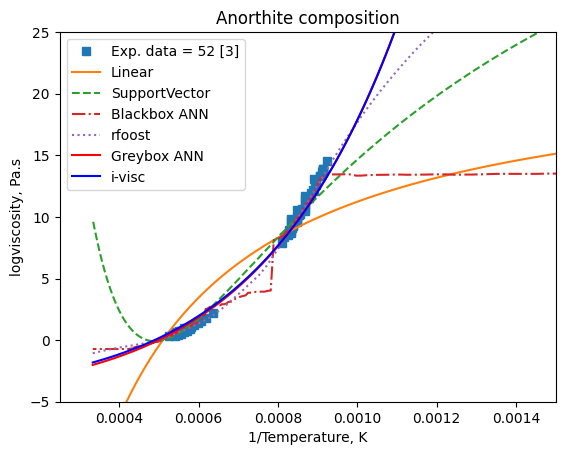

In [75]:
# Composition Anorthite Scarfe et al 1983

# loading data of interest
di_ = ds.dataset_lp.loc[(ds.dataset_lp.Name_publi=="Anorthite")|
                     (ds.dataset_lp.Name_publi=="An100")|
                     (ds.dataset_lp.Name_publi=="an100")|
                     (ds.dataset_lp.Name_publi=="An"),:].reset_index()

T_interest = np.linspace(500, 3000.0, 200)
P_interest = np.zeros(len(T_interest))
predictions_anorthite = predict_one_compo(di_, ds, models_list, T_interest, P_interest)

# figure
plt.figure()
plt.plot(1/di_.loc[:,"T"], di_.viscosity,"s",label="Exp. data = 52 [3]")
plt.plot(1/T_interest, predictions_anorthite[0],"-",label="Linear")
plt.plot(1/T_interest, predictions_anorthite[1],"--",label="SupportVector")
plt.plot(1/T_interest, predictions_anorthite[2],"-.",label="Blackbox ANN")
plt.plot(1/T_interest, predictions_anorthite[3],":", label="rfoost")
plt.plot(1/T_interest, predictions_anorthite[4],"r-", label="Greybox ANN")
plt.plot(1/T_interest, predictions_anorthite[5],"b-", label="i-visc")
plt.legend(loc='best')
plt.ylim(-5,25)
plt.xlim(0.00025,0.0015)
plt.xlabel('1/Temperature, K')
plt.ylabel('logviscosity, Pa.s')
plt.title('Anorthite composition')
print('Number of data =',di_.shape[0])

7/7 [==============================] - 0s 2ms/step
Number of data = 76


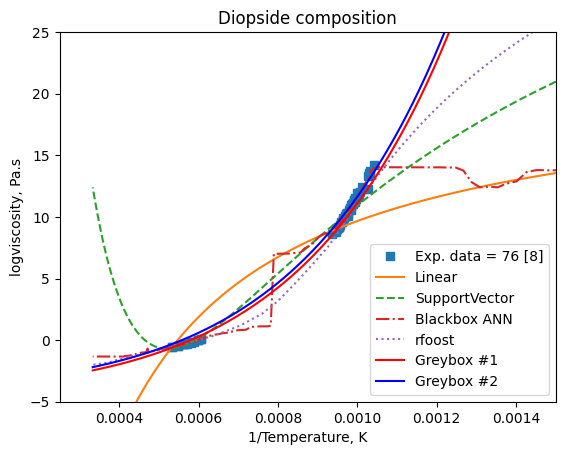

In [77]:
# Composition peridotide

# loading data of interest
di_ = ds.dataset_lp.loc[(ds.dataset_lp.Name_publi=="Diopside")|
                     (ds.dataset_lp.Name_publi=="di100")|
                     (ds.dataset_lp.Name_publi=="Di"),:].reset_index()

T_interest = np.linspace(500, 3000.0, 200)
P_interest = np.zeros(len(T_interest))
predictions_diopside = predict_one_compo(di_, ds, models_list, T_interest, P_interest)

# figure
plt.figure()
plt.plot(1/di_.loc[:,"T"], di_.viscosity,"s",label="Exp. data = 76 [8]")
plt.plot(1/T_interest, predictions_diopside[0],"-",label="Linear")
plt.plot(1/T_interest, predictions_diopside[1],"--",label="SupportVector")
plt.plot(1/T_interest, predictions_diopside[2],"-.",label="Blackbox ANN")
plt.plot(1/T_interest, predictions_diopside[3],":", label="rfoost")
plt.plot(1/T_interest, predictions_diopside[4],"r-", label="Greybox #1")
plt.plot(1/T_interest, predictions_diopside[5],"b-", label="Greybox #2")
plt.legend(loc='best')
plt.ylim(-5,25)
plt.xlim(0.00025,0.0015)
plt.xlabel('1/Temperature, K')
plt.ylabel('logviscosity, Pa.s')
plt.title('Diopside composition')
print('Number of data =',di_.shape[0])

4/4 [==============================] - 0s 1ms/step
Number of data = 27


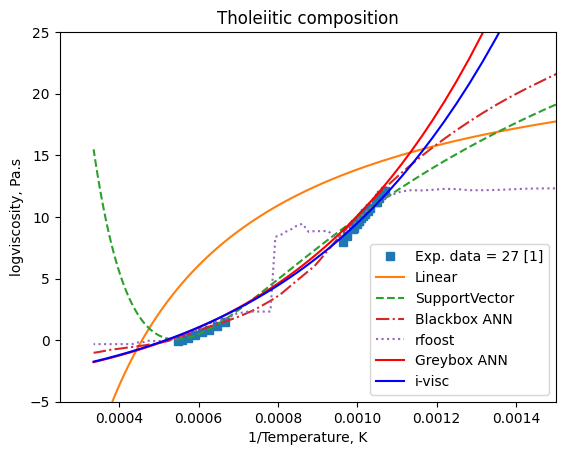

In [19]:
# Composition tholeiitic melt 
#Remelted continental rift basalt erupted 2002, Mt. Nyiragongo, DR of Congo

# loading data of interest
di_ = dataset_lp.loc[(dataset_lp.Name_publi=="NYI")&
                     (dataset_lp.ref=="Sehlke and Whittington 2016"),:].reset_index()

# add descriptors
xi_ = utils.descriptors(di_.loc[:, utils.list_oxides()]/100).values

# temperature axis for interpolation
T_interest = np.arange(500, 3000, 20.)

# pressure axis for interpolation
P_interest = np.zeros(len(T_interest))

# same composition so we get first line, then create an array with interesting temps
xi = np.ones((len(T_interest),xi_.shape[1]))*xi_[0,:]

# transformation
xi_s = np.concatenate((T_interest.reshape(-1,1),
                            P_interest.reshape(-1,1),
                            xi),axis=1)

xi_grey = np.concatenate((  P_interest.reshape(-1,1),
                            xi),axis=1)

# predictions 
oneC_lin = clf_linreg.predict(std.transform(xi_s))
oneC_svr = clf_svr.predict(std.transform(xi_s))
oneC_nn = clf_nn.predict(std.transform(xi_s))
oneC_rf = clf_rf.predict(std.transform(xi_s))
oneC_grey = model.predict((std2.transform(xi_grey), T_interest.reshape(-1,1)))
oneC_ivisc = neuralmodel.predict(torch.FloatTensor(xi),
                                 torch.FloatTensor(T_interest).reshape(-1,1),
                                 torch.FloatTensor(P_interest).reshape(-1,1))

# figure
plt.figure()
plt.plot(1/di_.loc[:,"T"], di_.viscosity,"s",label="Exp. data = 27 [1]")
plt.plot(1/T_interest, oneC_lin,"-",label="Linear")
plt.plot(1/T_interest, oneC_svr,"--",label="SupportVector")
plt.plot(1/T_interest, oneC_nn,"-.",label="Blackbox ANN")
plt.plot(1/T_interest, oneC_rf,":", label="rfoost")
plt.plot(1/T_interest, oneC_grey+6.25,"r-", label="Greybox ANN")
plt.plot(1/T_interest, oneC_ivisc.detach().numpy(),"b-", label="i-visc")
plt.legend(loc='best')
plt.ylim(-5,25)
plt.xlim(0.00025,0.0015)
plt.xlabel('1/Temperature, K')
plt.ylabel('logviscosity, Pa.s')
plt.title('Tholeiitic composition')
print('Number of data =',di_.shape[0])

4/4 [==============================] - 0s 1ms/step
Number of data = 27


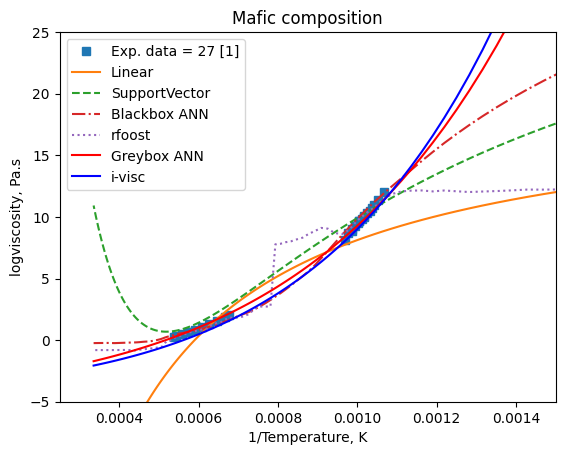

In [20]:
# Composition mafic melt 
# Remelted continental flood basalt, Chengwatana, WI

# loading data of interest
di_ = dataset_lp.loc[(dataset_lp.Name_publi=="CHW")&
                     (dataset_lp.ref=="Sehlke and Whittington 2016"),:].reset_index()

# add descriptors
xi_ = utils.descriptors(di_.loc[:, utils.list_oxides()]/100).values

# temperature axis for interpolation
T_interest = np.arange(500, 3000, 20.)

# pressure axis for interpolation
P_interest = np.zeros(len(T_interest))

# same composition so we get first line, then create an array with interesting temps
xi = np.ones((len(T_interest),xi_.shape[1]))*xi_[0,:]

# transformation
xi_s = np.concatenate((T_interest.reshape(-1,1),
                            P_interest.reshape(-1,1),
                            xi),axis=1)

xi_grey = np.concatenate((  P_interest.reshape(-1,1),
                            xi),axis=1)

# predictions 
oneC_lin = clf_linreg.predict(std.transform(xi_s))
oneC_svr = clf_svr.predict(std.transform(xi_s))
oneC_nn = clf_nn.predict(std.transform(xi_s))
oneC_rf = clf_rf.predict(std.transform(xi_s))
oneC_grey = model.predict((std2.transform(xi_grey), T_interest.reshape(-1,1)))
oneC_ivisc = neuralmodel.predict(torch.FloatTensor(xi),
                                 torch.FloatTensor(T_interest).reshape(-1,1),
                                 torch.FloatTensor(P_interest).reshape(-1,1))

# figure
plt.figure()
plt.plot(1/di_.loc[:,"T"], di_.viscosity,"s",label="Exp. data = 27 [1]")
plt.plot(1/T_interest, oneC_lin,"-",label="Linear")
plt.plot(1/T_interest, oneC_svr,"--",label="SupportVector")
plt.plot(1/T_interest, oneC_nn,"-.",label="Blackbox ANN")
plt.plot(1/T_interest, oneC_rf,":", label="rfoost")
plt.plot(1/T_interest, oneC_grey+6.25,"r-", label="Greybox ANN")
plt.plot(1/T_interest, oneC_ivisc.detach().numpy(),"b-", label="i-visc")
plt.legend(loc='best')
plt.ylim(-5,25)
plt.xlim(0.00025,0.0015)
plt.xlabel('1/Temperature, K')
plt.ylabel('logviscosity, Pa.s')
plt.title('Mafic composition')
print('Number of data =',di_.shape[0])

4/4 [==============================] - 0s 1ms/step
Number of data = 23


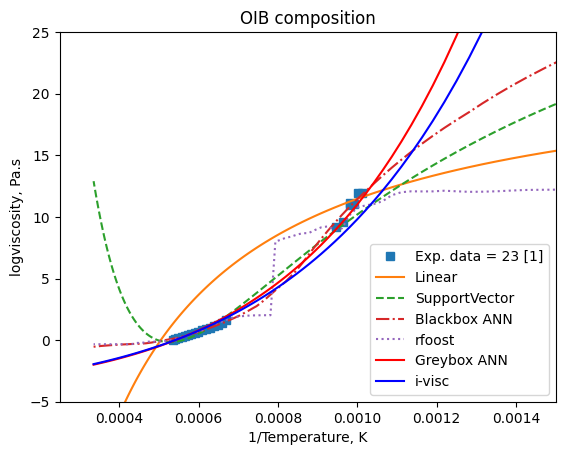

In [21]:
# Composition OIB melt 
# Remelted OIB, Mauna Ulu, Kilauea, HI

# loading data of interest
di_ = dataset_lp.loc[(dataset_lp.Name_publi=="MU-Fe")&
                     (dataset_lp.ref=="Sehlke and Whittington 2016"),:].reset_index()

# add descriptors
xi_ = utils.descriptors(di_.loc[:, utils.list_oxides()]/100).values

# temperature axis for interpolation
T_interest = np.arange(500, 3000, 20.)

# pressure axis for interpolation
P_interest = np.zeros(len(T_interest))

# same composition so we get first line, then create an array with interesting temps
xi = np.ones((len(T_interest),xi_.shape[1]))*xi_[0,:]

# transformation
xi_s = np.concatenate((T_interest.reshape(-1,1),
                            P_interest.reshape(-1,1),
                            xi),axis=1)

xi_grey = np.concatenate((  P_interest.reshape(-1,1),
                            xi),axis=1)

# predictions 
oneC_lin = clf_linreg.predict(std.transform(xi_s))
oneC_svr = clf_svr.predict(std.transform(xi_s))
oneC_nn = clf_nn.predict(std.transform(xi_s))
oneC_rf = clf_rf.predict(std.transform(xi_s))
oneC_grey = model.predict((std2.transform(xi_grey), T_interest.reshape(-1,1)))
oneC_ivisc = neuralmodel.predict(torch.FloatTensor(xi),
                                 torch.FloatTensor(T_interest).reshape(-1,1),
                                 torch.FloatTensor(P_interest).reshape(-1,1))

# figure
plt.figure()
plt.plot(1/di_.loc[:,"T"], di_.viscosity,"s",label="Exp. data = 23 [1]")
plt.plot(1/T_interest, oneC_lin,"-",label="Linear")
plt.plot(1/T_interest, oneC_svr,"--",label="SupportVector")
plt.plot(1/T_interest, oneC_nn,"-.",label="Blackbox ANN")
plt.plot(1/T_interest, oneC_rf,":", label="rfoost")
plt.plot(1/T_interest, oneC_grey+6.25,"r-", label="Greybox ANN")
plt.plot(1/T_interest, oneC_ivisc.detach().numpy(),"b-", label="i-visc")
plt.legend(loc='best')
plt.ylim(-5,25)
plt.xlim(0.00025,0.0015)
plt.xlabel('1/Temperature, K')
plt.ylabel('logviscosity, Pa.s')
plt.title('OIB composition')
print('Number of data =',di_.shape[0])

4/4 [==============================] - 0s 2ms/step
Number of data = 11


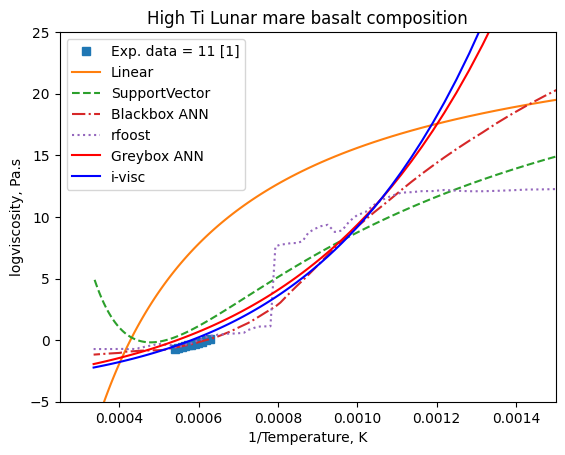

In [22]:
# Composition MOON melt 
# Synth. high-Ti lunar mare basalt

# loading data of interest
di_ = dataset_lp.loc[(dataset_lp.Name_publi=="LM")&
                     (dataset_lp.ref=="Sehlke and Whittington 2016"),:].reset_index()

# add descriptors
xi_ = utils.descriptors(di_.loc[:, utils.list_oxides()]/100).values

# temperature axis for interpolation
T_interest = np.arange(500, 3000, 20.)

# pressure axis for interpolation
P_interest = np.zeros(len(T_interest))

# same composition so we get first line, then create an array with interesting temps
xi = np.ones((len(T_interest),xi_.shape[1]))*xi_[0,:]

# transformation
xi_s = np.concatenate((T_interest.reshape(-1,1),
                            P_interest.reshape(-1,1),
                            xi),axis=1)

xi_grey = np.concatenate((  P_interest.reshape(-1,1),
                            xi),axis=1)

# predictions 
oneC_lin = clf_linreg.predict(std.transform(xi_s))
oneC_svr = clf_svr.predict(std.transform(xi_s))
oneC_nn = clf_nn.predict(std.transform(xi_s))
oneC_rf = clf_rf.predict(std.transform(xi_s))
oneC_grey = model.predict((std2.transform(xi_grey), T_interest.reshape(-1,1)))
oneC_ivisc = neuralmodel.predict(torch.FloatTensor(xi),
                                 torch.FloatTensor(T_interest).reshape(-1,1),
                                 torch.FloatTensor(P_interest).reshape(-1,1))

# figure
plt.figure()
plt.plot(1/di_.loc[:,"T"], di_.viscosity,"s",label="Exp. data = 11 [1]")
plt.plot(1/T_interest, oneC_lin,"-",label="Linear")
plt.plot(1/T_interest, oneC_svr,"--",label="SupportVector")
plt.plot(1/T_interest, oneC_nn,"-.",label="Blackbox ANN")
plt.plot(1/T_interest, oneC_rf,":", label="rfoost")
plt.plot(1/T_interest, oneC_grey+6.25,"r-", label="Greybox ANN")
plt.plot(1/T_interest, oneC_ivisc.detach().numpy(),"b-", label="i-visc")
plt.legend(loc='best')
plt.ylim(-5,25)
plt.xlim(0.00025,0.0015)
plt.xlabel('1/Temperature, K')
plt.ylabel('logviscosity, Pa.s')
plt.title('High Ti Lunar mare basalt composition')
print('Number of data =',di_.shape[0])

4/4 [==============================] - 0s 1ms/step
Number of data = 30


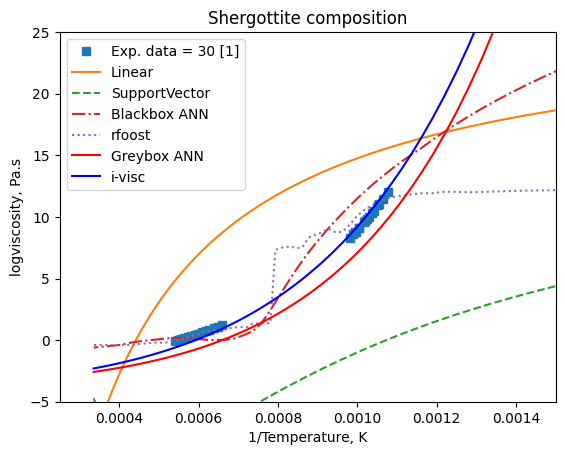

In [23]:
# Composition Mars melt 
# Shergottite Mars composition

# loading data of interest
di_ = dataset_lp.loc[(dataset_lp.Name_publi=="SHG")&
                     (dataset_lp.ref=="Sehlke and Whittington 2016"),:].reset_index()

# add descriptors
xi_ = utils.descriptors(di_.loc[:, utils.list_oxides()]/100).values

# temperature axis for interpolation
T_interest = np.arange(500, 3000, 20.)

# pressure axis for interpolation
P_interest = np.zeros(len(T_interest))

# same composition so we get first line, then create an array with interesting temps
xi = np.ones((len(T_interest),xi_.shape[1]))*xi_[0,:]

# transformation
xi_s = np.concatenate((T_interest.reshape(-1,1),
                            P_interest.reshape(-1,1),
                            xi),axis=1)

xi_grey = np.concatenate((  P_interest.reshape(-1,1),
                            xi),axis=1)

# predictions 
oneC_lin = clf_linreg.predict(std.transform(xi_s))
oneC_svr = clf_svr.predict(std.transform(xi_s))
oneC_nn = clf_nn.predict(std.transform(xi_s))
oneC_rf = clf_rf.predict(std.transform(xi_s))
oneC_grey = model.predict((std2.transform(xi_grey), T_interest.reshape(-1,1)))
oneC_ivisc = neuralmodel.predict(torch.FloatTensor(xi),
                                 torch.FloatTensor(T_interest).reshape(-1,1),
                                 torch.FloatTensor(P_interest).reshape(-1,1))

# figure
plt.figure()
plt.plot(1/di_.loc[:,"T"], di_.viscosity,"s",label="Exp. data = 30 [1]")
plt.plot(1/T_interest, oneC_lin,"-",label="Linear")
plt.plot(1/T_interest, oneC_svr,"--",label="SupportVector")
plt.plot(1/T_interest, oneC_nn,"-.",label="Blackbox ANN")
plt.plot(1/T_interest, oneC_rf,":", label="rfoost")
plt.plot(1/T_interest, oneC_grey+6.25,"r-", label="Greybox ANN")
plt.plot(1/T_interest, oneC_ivisc.detach().numpy(),"b-", label="i-visc")
plt.legend(loc='best')
plt.ylim(-5,25)
plt.xlim(0.00025,0.0015)
plt.xlabel('1/Temperature, K')
plt.ylabel('logviscosity, Pa.s')
plt.title('Shergottite composition')
print('Number of data =',di_.shape[0])

# Prediction for one composition with Pressure

In [24]:
testcompo = pd.read_excel('./TestsCompo.xlsx', sheet_name='casio3P')
testcompo.head()

,P,T,sio2,tio2,al2o3,feo,fe2o3,mno,na2o,k2o,mgo,cao,p2o5,h2o,reference,Compo
0,1,1600,0.478452,0,0.0035,0.0006,0,0,0,0,0.0013,0.469153,0,0.046995,Cochain et al. 2017,CaSiO3
1,2,1600,0.478452,0,0.0035,0.0006,0,0,0,0,0.0013,0.469153,0,0.046995,Cochain et al. 2017,CaSiO3
2,3,1600,0.478452,0,0.0035,0.0006,0,0,0,0,0.0013,0.469153,0,0.046995,Cochain et al. 2017,CaSiO3
3,4,1600,0.478452,0,0.0035,0.0006,0,0,0,0,0.0013,0.469153,0,0.046995,Cochain et al. 2017,CaSiO3
4,5,1600,0.478452,0,0.0035,0.0006,0,0,0,0,0.0013,0.469153,0,0.046995,Cochain et al. 2017,CaSiO3


In [25]:
X_compo = utils.descriptors(testcompo.loc[:,utils.list_oxides()]).values
T_compo = testcompo['T'].values
P_compo = testcompo['P'].values
#y_compo = testcompo['y'].values
#other_compo = pd.concat([testcompo['reference'],testcompo['Name'],testcompo['Compo']], axis=1)
X_compo_PT = np.concatenate((T_compo.reshape(-1,1), P_compo.reshape(-1,1), X_compo),axis=1)
X_compo_grey = np.concatenate((P_compo.reshape(-1,1), X_compo),axis=1)


In [26]:
onePC_lin = clf_linreg.predict(std.transform(X_compo_PT))
onePC_svr = clf_svr.predict(std.transform(X_compo_PT))
onePC_nn = clf_nn.predict(std.transform(X_compo_PT))
onePC_rf = clf_rf.predict(std.transform(X_compo_PT))
onePC_grey = model.predict((std2.transform(X_compo_grey), T_compo.reshape(-1,1)))
onePC_ivisc = neuralmodel.predict(torch.FloatTensor(X_compo),
                                  torch.FloatTensor(T_compo).reshape(-1,1),
                                  torch.FloatTensor(P_compo).reshape(-1,1)).detach().numpy()

2/2 [==============================] - 0s 3ms/step


In [27]:
expdata = dataset_hp.loc[dataset_hp.Name_publi=="CaSiO3",:].reset_index()
expdata

,index,Name,sio2,tio2,al2o3,feo,fe2o3,mno,mgo,cao,...,P,T,viscosity,Sc,ref,Name_publi,Date Update,System,LineNumber,Compo_interest
0,0,staffmnkmcph_47.9_0_0.4_0.1_0_0_0.1_46.9_0_0_0...,47.85,0.0,0.35,0.06,0.0,0.0,0.13,46.92,...,1.1,1873,-0.73,NaN,Cochain et al. 2017,CaSiO3,NaN,NaN,NaN,NaN
1,1,staffmnkmcph_47.9_0_0.4_0.1_0_0_0.1_46.9_0_0_0...,47.85,0.0,0.35,0.06,0.0,0.0,0.13,46.92,...,1.8,1883,-0.78,NaN,Cochain et al. 2017,CaSiO3,NaN,NaN,NaN,NaN
2,2,staffmnkmcph_47.9_0_0.4_0.1_0_0_0.1_46.9_0_0_0...,47.85,0.0,0.35,0.06,0.0,0.0,0.13,46.92,...,3.4,1973,-0.80,NaN,Cochain et al. 2017,CaSiO3,NaN,NaN,NaN,NaN
3,3,staffmnkmcph_47.9_0_0.4_0.1_0_0_0.1_46.9_0_0_0...,47.85,0.0,0.35,0.06,0.0,0.0,0.13,46.92,...,4.3,1913,-0.93,NaN,Cochain et al. 2017,CaSiO3,NaN,NaN,NaN,NaN
4,4,staffmnkmcph_47.9_0_0.4_0.1_0_0_0.1_46.9_0_0_0...,47.85,0.0,0.35,0.06,0.0,0.0,0.13,46.92,...,5.9,2173,-0.96,NaN,Cochain et al. 2017,CaSiO3,NaN,NaN,NaN,NaN
5,5,staffmnkmcph_47.9_0_0.4_0.1_0_0_0.1_46.9_0_0_0...,47.85,0.0,0.35,0.06,0.0,0.0,0.13,46.92,...,6.1,2008,-1.00,NaN,Cochain et al. 2017,CaSiO3,NaN,NaN,NaN,NaN
6,6,staffmnkmcph_47.9_0_0.4_0.1_0_0_0.1_46.9_0_0_0...,47.85,0.0,0.35,0.06,0.0,0.0,0.13,46.92,...,6.4,2128,-0.98,NaN,Cochain et al. 2017,CaSiO3,NaN,NaN,NaN,NaN
7,7,staffmnkmcph_47.9_0_0.4_0.1_0_0_0.1_46.9_0_0_0...,47.85,0.0,0.35,0.06,0.0,0.0,0.13,46.92,...,6.8,2061,-0.99,NaN,Cochain et al. 2017,CaSiO3,NaN,NaN,NaN,NaN


Number of data = 8


Text(0.5, 0, 'Pressure, GPa')

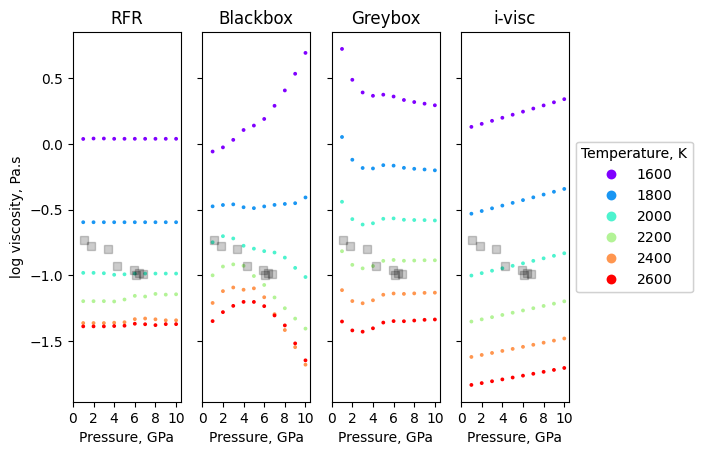

In [28]:
fig=plt.figure()
ax1=plt.subplot(141)
ax2=plt.subplot(142,sharey=ax1,sharex=ax1)
ax3=plt.subplot(143,sharey=ax2,sharex=ax1)
ax4=plt.subplot(144,sharey=ax3,sharex=ax1)
ax1.plot(expdata['P'],expdata['viscosity'],'ks',alpha=0.2)
#ax1.errorbar(expdata['P'],expdata['viscosity'],0.5,ecolor='black',alpha=0.2)
ax2.plot(expdata['P'],expdata['viscosity'],'ks',alpha=0.2)
#ax2.errorbar(expdata['P'],expdata['viscosity'],0.5,ecolor='black',alpha=0.2)
ax3.plot(expdata['P'],expdata['viscosity'],'ks',alpha=0.2)
#ax3.errorbar(expdata['P'],expdata['viscosity'],0.5,ecolor='black',alpha=0.2)
ax4.plot(expdata['P'],expdata['viscosity'],'ks',alpha=0.2)
#ax4.errorbar(expdata['P'],expdata['viscosity'],0.5,ecolor='black',alpha=0.2)

#plt.plot(di3_.loc[:,"P"], di3_.viscosity,"s",label="Data")
#plt.plot(P_compo, onePC_lin,"-",label="Linear")
#plt.plot(P_compo, onePC_svr,"--",label="SupportVector")
ax1.scatter(P_compo, onePC_rf,cmap='rainbow',c=T_compo,s=3)
ax2.scatter(P_compo, onePC_nn,cmap='rainbow',c=T_compo,s=3)
ax3.scatter(P_compo, onePC_grey+6.25,cmap='rainbow',c=T_compo,s=3)
Tlegend = ax4.scatter(P_compo, onePC_ivisc,cmap='rainbow',c=T_compo,s=3)
#plt.legend(['1600', '1800', '2000', '2400', '2600'],loc='best')
#plt.ylim(-5,4)
#plt.xlim(0,10)
ax1.set_title('RFR')
ax2.set_title('Blackbox')
ax3.set_title('Greybox')
ax4.set_title('i-visc')
print('Number of data =',expdata.shape[0])
plt.setp(ax2.get_yticklabels(), visible=False)
plt.setp(ax3.get_yticklabels(), visible=False)
plt.setp(ax4.get_yticklabels(), visible=False)
ax1.set_ylabel('log viscosity, Pa.s')
#fig.add_artist()
#fig.set_figwidth(7)
# produce a legend with the unique colors from the scatter
legend = ax4.legend(*Tlegend.legend_elements(),
                    loc="center left", bbox_to_anchor=(1,0.5), title="Temperature, K")
fig.add_artist(legend)
ax1.set_xticks(np.arange(0,11,2))
ax1.set_xlabel('Pressure, GPa')
ax2.set_xlabel('Pressure, GPa')
ax3.set_xlabel('Pressure, GPa')
ax4.set_xlabel('Pressure, GPa')

# onecompo - All models comparaison with ivisc

In [29]:
testperidot = pd.read_excel('./TestsCompo.xlsx', sheet_name='peridotite_2')
X_peridot = utils.descriptors(testperidot.loc[:,utils.list_oxides()]).values
T_peridot = testperidot['T'].values
P_peridot = testperidot['P'].values
X_peridot_PT = np.concatenate((T_peridot.reshape(-1,1), P_peridot.reshape(-1,1), X_peridot),axis=1)
X_peridot_grey = np.concatenate((P_peridot.reshape(-1,1), X_peridot),axis=1)


In [30]:
datatestperidot = pd.read_excel('./TestsCompo.xlsx', sheet_name='Data')
# loading data of interest
di_ = datatestperidot.loc[(datatestperidot.Compo=="Peridotite")|
                          (datatestperidot.Compo=="Peridotite_2"),:].reset_index()

dataX_peridot = utils.descriptors(di_.loc[:,utils.list_oxides()]).values
dataT_peridot = di_['T'].values
dataP_peridot = di_['P'].values
dataX_peridot_PT = np.concatenate((dataT_peridot.reshape(-1,1), dataP_peridot.reshape(-1,1), dataX_peridot),axis=1)
dataX_peridot_grey = np.concatenate((dataP_peridot.reshape(-1,1), dataX_peridot),axis=1)


In [31]:
dataP_peridot

array([ 7. , 16. , 21. , 25. , 11. ,  2.8,  4.7,  7.3,  3.8,  4.2,  4.2,
        2.8,  2.8,  6.4,  5. ,  6.4, 11.1, 11.1,  9.8,  9.8,  8.1,  8.1,
        2.3,  2.3, 13. , 13. ])

In [32]:
peridot_lin = clf_linreg.predict(std.transform(X_peridot_PT))
peridot_svr = clf_svr.predict(std.transform(X_peridot_PT))
peridot_nn = clf_nn.predict(std.transform(X_peridot_PT))
peridot_rf = clf_rf.predict(std.transform(X_peridot_PT))
peridot_grey = model.predict((std2.transform(X_peridot_grey), T_peridot.reshape(-1,1)))
peridot_ivisc = neuralmodel.predict(torch.FloatTensor(X_peridot),
                                 torch.FloatTensor(T_peridot).reshape(-1,1),
                                 torch.FloatTensor(P_peridot).reshape(-1,1))


2/2 [==============================] - 0s 2ms/step


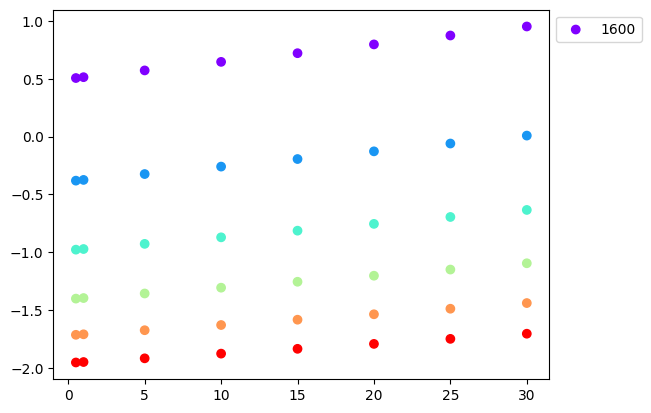

In [33]:
plt.scatter(P_peridot,peridot_ivisc.detach().numpy(),cmap='rainbow',c=T_peridot)
plt.legend(T_peridot,bbox_to_anchor=(1,1))

''

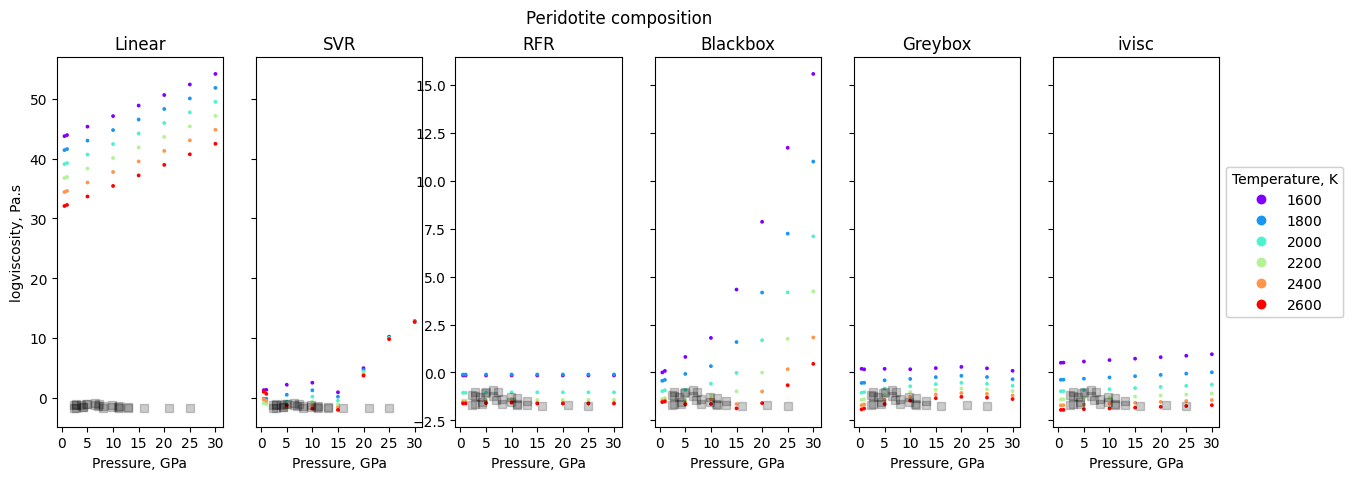

In [34]:
fig=plt.figure()
ax1=plt.subplot(161)
ax2=plt.subplot(162,sharey=ax1)
ax3=plt.subplot(163)
ax4=plt.subplot(164,sharey=ax3)
ax5=plt.subplot(165,sharey=ax4)
ax6=plt.subplot(166,sharey=ax5)
#ax1.plot(albite['P'],albite['viscosity'],'ks',alpha=0.2)
#ax2.plot(albite['P'],albite['viscosity'],'ks',alpha=0.2)
#ax3.plot(albite['P'],albite['viscosity'],'ks',alpha=0.2)
    
#plt.plot(di3_.loc[:,"P"], di3_.viscosity,"s",label="Data")
#plt.plot(P_compo, onePC_lin,"-",label="Linear")
#plt.plot(P_compo, onePC_svr,"--",label="SupportVector")
ax1.scatter(P_peridot, peridot_lin,cmap='rainbow',c=T_peridot,s=3)
ax2.scatter(P_peridot, peridot_svr,cmap='rainbow',c=T_peridot,s=3)
ax3.scatter(P_peridot, peridot_rf,cmap='rainbow',c=T_peridot,s=3)
ax4.scatter(P_peridot, peridot_nn,cmap='rainbow',c=T_peridot,s=3)
ax5.scatter(P_peridot, peridot_grey+6.25,cmap='rainbow',c=T_peridot,s=3)
Tlegend = ax6.scatter(P_peridot, peridot_ivisc.detach().numpy(),cmap='rainbow',c=T_peridot,s=3)

#plt.legend(['1600', '1800', '2000', '2400', '2600'],loc='best')
#plt.ylim(-5,4)
#plt.xlim(0.00025,0.001)
ax1.set_title('Linear')
ax2.set_title('SVR')
ax3.set_title('RFR')
ax4.set_title('Blackbox')
ax5.set_title('Greybox')
ax6.set_title('ivisc')
#print('Number of data =',testcompo.shape[0])
plt.suptitle('Peridotite composition')
ax1.set_ylabel('logviscosity, Pa.s')
ax1.set_xlabel('Pressure, GPa')
ax2.set_xlabel('Pressure, GPa')
ax3.set_xlabel('Pressure, GPa')
ax4.set_xlabel('Pressure, GPa')
ax5.set_xlabel('Pressure, GPa')
ax6.set_xlabel('Pressure, GPa')
ax1.set_xticks([0,5,10,15,20,25,30])
ax2.set_xticks([0,5,10,15,20,25,30])
ax3.set_xticks([0,5,10,15,20,25,30])
ax4.set_xticks([0,5,10,15,20,25,30])
ax5.set_xticks([0,5,10,15,20,25,30])
ax6.set_xticks([0,5,10,15,20,25,30])

# produce a legend with the unique colors from the scatter
legend = ax6.legend(*Tlegend.legend_elements(),
                    loc="center left", bbox_to_anchor=(1,0.5), title="Temperature, K")
fig.add_artist(legend)
fig.set_figwidth(15)
plt.setp(ax2.get_yticklabels(), visible=False)
#plt.setp(ax3.get_yticklabels(), visible=False)
plt.setp(ax4.get_yticklabels(), visible=False)
plt.setp(ax5.get_yticklabels(), visible=False)
plt.setp(ax6.get_yticklabels(), visible=False)

ax1.plot(di_["P"],di_['y'], "ks", alpha=0.2 )
ax2.plot(di_["P"],di_['y'], "ks", alpha=0.2 )
ax3.plot(di_["P"],di_['y'], "ks", alpha=0.2 )
ax4.plot(di_["P"],di_['y'], "ks", alpha=0.2 )
ax5.plot(di_["P"],di_['y'], "ks", alpha=0.2 )
ax6.plot(di_["P"],di_['y'], "ks", alpha=0.2 )

;

In [35]:
testperidot

,P,T,sio2,tio2,al2o3,feo,fe2o3,mno,na2o,k2o,mgo,cao,p2o5,h2o,reference,Compo
0,0.5,1600,0.4038,0,0.0204,0.063,0,0,0,0,0.4793,0.0334,0,0,Liebske et al. 2005,Peridotite_2
1,1.0,1600,0.4038,0,0.0204,0.063,0,0,0,0,0.4793,0.0334,0,0,Liebske et al. 2005,Peridotite_2
2,5.0,1600,0.4038,0,0.0204,0.063,0,0,0,0,0.4793,0.0334,0,0,Liebske et al. 2005,Peridotite_2
3,10.0,1600,0.4038,0,0.0204,0.063,0,0,0,0,0.4793,0.0334,0,0,Liebske et al. 2005,Peridotite_2
4,15.0,1600,0.4038,0,0.0204,0.063,0,0,0,0,0.4793,0.0334,0,0,Liebske et al. 2005,Peridotite_2
5,20.0,1600,0.4038,0,0.0204,0.063,0,0,0,0,0.4793,0.0334,0,0,Liebske et al. 2005,Peridotite_2
6,25.0,1600,0.4038,0,0.0204,0.063,0,0,0,0,0.4793,0.0334,0,0,Liebske et al. 2005,Peridotite_2
7,30.0,1600,0.4038,0,0.0204,0.063,0,0,0,0,0.4793,0.0334,0,0,Liebske et al. 2005,Peridotite_2
8,0.5,1800,0.4038,0,0.0204,0.063,0,0,0,0,0.4793,0.0334,0,0,Liebske et al. 2005,Peridotite_2
9,1.0,1800,0.4038,0,0.0204,0.063,0,0,0,0,0.4793,0.0334,0,0,Liebske et al. 2005,Peridotite_2


# All HP composition

In [38]:
# initial data import

dataset_lp = pd.read_excel("./data/database.xlsx", sheet_name="lp")
dataset_hp = pd.read_excel("./data/database.xlsx", sheet_name="hp")

std = load('./data/ScalerT.joblib')
std2 = load('./data/ScalerP.joblib')

/Users/charleslelosq/anaconda3/envs/ml/lib/python3.9/site-packages/sklearn/base.py:288: UserWarning: Trying to unpickle estimator StandardScaler from version 1.3.2 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [39]:
# reading the Pandas dataframe
dataset_hp_ = utils.chimie_control(dataset_hp)
XX_hp_ = utils.descriptors(dataset_hp_.loc[:,utils.list_oxides()])
XX_hp = np.concatenate((dataset_hp_.loc[:,"P"].values.reshape(-1,1), XX_hp_),axis=1)

oneC_greyhp = model.predict((std2.transform(XX_hp), dataset_hp.loc[:,"T"].values.reshape(-1,1)))+6.25
oneC_ivisc = neuralmodel.predict(torch.FloatTensor(XX_hp_.to_numpy()),
                                 torch.FloatTensor(dataset_hp_.loc[:,"T"].values.reshape(-1,1)).reshape(-1,1),
                                 torch.FloatTensor(dataset_hp_.loc[:,"P"].values.reshape(-1,1)).reshape(-1,1))


34/34 [==============================] - 0s 1ms/step


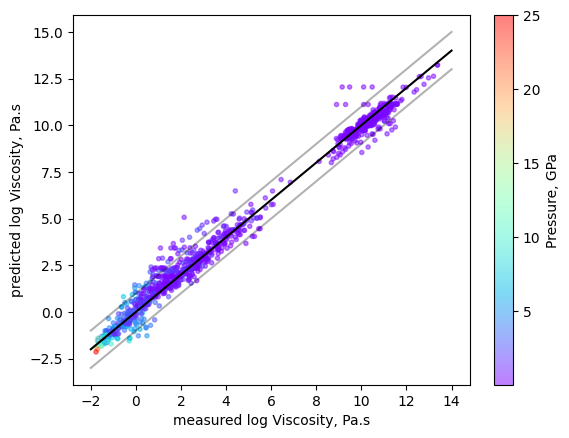

In [40]:
plt.plot([-2,14],[-2,14],'k')
plt.plot([-2,14],[-3,13],'k',alpha=0.3)
plt.plot([-2,14],[-1,15],'k',alpha=0.3)
plt.scatter(dataset_hp.loc[:,'viscosity'].values.reshape(-1,1),
            oneC_ivisc.detach().numpy(),
            cmap='rainbow',
            c=dataset_hp_.loc[:,"P"].values.reshape(-1,1),
            marker='.',
            alpha = 0.5
           )
plt.xlabel('measured log Viscosity, Pa.s')
plt.ylabel('predicted log Viscosity, Pa.s')
plt.colorbar(label='Pressure, GPa')